In [2]:
%matplotlib inline

Heatmap of Convolutional Neural Networks: CAM
--------
We are going to show input images that minimize the loss of a convolution network for a specific layer and filter.
Adapted from Luyu's work https://github.com/luyucen/math6380o/blob/master/Test_featureExtract_heatmap.ipynb

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import sklearn.metrics
from skimage.measure import label
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time
import os
import copy
import glob
import ntpath
import pandas as pd

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),


}

data_dir = '/home/kaiyihuang/nexperia/new_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

In [20]:
def im(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # The input is CXHXW, the output is HXWXC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


def plot_activ(model, num_images=4):
    """Heatmaps for batches of images loaded from dataloaders"""
    weights = model.fc.weight # size[45,512]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    m = m.to(device) # define the operation of upsampling to the image size
    m_2 = nn.Softmax(dim=1)
    m_2 = m_2.to(device) # softmax layer added to the output to obatin probability
    images_so_far = 0
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        batch_size = inputs.size()[0]
        outputs = model(inputs)
        last_conv_outputs = resnet_conv(inputs)# size[batch_size, 512, 7, 7]
        act_maps = m(last_conv_outputs)# size[batch_size, 512, 224, 224]
        scores, preds = torch.max(m_2(outputs), 1)
        
        for j in range(batch_size):
            out = torch.zeros(224,224)
            for k in range(512):
                out = out + weights[preds[j]][k]*act_maps[j,k,:,:]
            images_so_far += 1
            ax = plt.subplot(num_images, 2, images_so_far*2-1)
            ax.set_title('{}:{}'.format(class_names[preds[j]], scores[j]))
            ax.imshow(im(inputs.cpu().data[j]))
            ax.imshow(out.cpu().data, cmap='jet', alpha=0.35)
            ax.axis('off')
            ax2 = plt.subplot(num_images, 2, images_so_far*2)
            ax2.imshow(im(inputs.cpu().data[j]))
            ax2.set_title('{}:{}'.format(class_names[preds[j]], scores[j]))
            ax2.axis('off')
            if images_so_far == num_images:
                return
            
def plot_cam_given(model, image_path, class_idx, box=None, filename=None, box_coord=None):
    '''heatmap and bounding box for one image'''
    
    img = Image.open(image_path).convert('RGB')# note that this was a grayscale image
    img_tensor = data_transforms['val'](img).view(1,3,224,224)
    weights = model.fc.weight # size[10,512]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    
    # define the operation of upsampling to the image size
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    # define the operation of softmax to get the probability of each class
    sftm = nn.Softmax()
    
    m = m.to(device) 
    sftm = sftm.to(device)
    img_tensor = img_tensor.to(device)
    
    output = model(img_tensor)
    
    scores = sftm(output)
    last_conv_output = resnet_conv(img_tensor)
    act_maps = m(last_conv_output)
    pred = torch.argmax(scores)
    out = torch.zeros(224,224)
    out_2 = torch.zeros(10,224,224)


    # weighted sum of activation maps
    for k in range(512):
        out = out + weights[pred, k]*torch.squeeze(act_maps[0,k,:,:])
        for i in range(10):
            out_2[i,:,:] = out_2[i,:,:] + weights[i, k]*torch.squeeze(act_maps[0,k,:,:])
            
    # original image vs image with heatmap, side by side plot 
    fig, axs = plt.subplots(3,5, figsize=(20, 20))
    
    axs = axs.ravel()
    
    axs[0].set_aspect(1)
        
    if box is not None:
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle(box, outline ="white") 
    elif (box_coord is not None):
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle([(box_coord[0],box_coord[1]),(box_coord[2],box_coord[3])], outline ="white") 
        
    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')
    
    axs[1].imshow(img)
    axs[1].imshow(out_2[class_idx,:,:].cpu().data, cmap='jet', alpha=0.35)
    axs[1].axis('off')
    axs[1].set_title('{}:{:.2e}'.format(class_names[class_idx], scores.cpu().data[0][class_idx]))
    left, bottom, width, height = bbox(out_2[class_idx,:,:].detach().numpy())
    # Create a Rectangle patch
    rect = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    axs[1].add_patch(rect)
    
    for i in range(3):
        axs[i+2].axis('off')
    
    for i in range(10):
    
        axs[i+5].imshow(img)
        axs[i+5].imshow(out_2[i,:,:].cpu().data, cmap='jet', alpha=0.35)
        axs[i+5].axis('off')
        axs[i+5].set_title('{}:{:.2e}'.format(class_names[i], scores.cpu().data[0][i]))
        left, bottom, width, height = bbox(out_2[i,:,:].detach().numpy())
        # Create a Rectangle patch
        rect_2 = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
        # Add the patch to the Axes
        axs[i+5].add_patch(rect_2)


    plt.show()
    
        
def bbox(heatmap, threshold=0.5):
    '''
        heatmap: a numpy array
        return: left, bottom indices, and width, height of the box
    '''
    m = heatmap.max()
    mask = 1*np.array(heatmap>threshold*m)
    labels = label(mask)
    if labels.max() == 0: # assume at least 1 CC
        return 0, heatmap.shape[0]-1, heatmap.shape[1]-1, 1-heatmap.shape[0]
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    Icol = largestCC.sum(axis=0)>0
    Irow = largestCC.sum(axis=1)>0
    colIndices = np.where(Icol)[0]
    rowIndices = np.where(Irow)[0]
    left = colIndices[0]
    right = colIndices[colIndices.size-1]
    top = rowIndices[0]
    bottom = rowIndices[rowIndices.size-1]
    return left, bottom, right-left, top-bottom

In [21]:
def showimgs(start, filenames, scores, my_dir):
    if start>=len(filenames):
        start = 0
    
    img1 = Image.open(os.path.join(my_dir, filenames[start]))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img1)
    plt.title(scores[start])
    plt.axis('off')
    start+=1
    
    img2 = Image.open(os.path.join(my_dir, filenames[start]))
    plt.subplot(1, 3, 2)
    plt.imshow(img2)
    plt.title(scores[start])
    plt.axis('off')
    start+=1
    
    img3 = Image.open(os.path.join(my_dir, filenames[start]))
    plt.subplot(1, 3, 3)
    plt.imshow(img3)
    plt.title(scores[start])
    plt.axis('off')

    plt.show()

Multi-label
---

In [22]:
ecoc = torch.zeros(10,45)
n = 0
for i in range(9):
    for j in range(i+1,10):
        ecoc[i,n] = 1
        ecoc[j,n] = -1
        n+=1

In [43]:
def plot_cam_given_multi_label(model, image_path, class_idx, box=None, filename=None, box_coord=None):
    '''heatmap and bounding box for one image'''
    
    img = Image.open(image_path).convert('RGB')# note that this was a grayscale image
    img_tensor = data_transforms['val'](img).view(1,3,224,224)
    weights = model.fc.weight # size[45,512]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    
    # define the operation of upsampling to the image size
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    # define the operation of softmax to get the probability of each class
    sftm = nn.Softmax()
    
    m = m.to(device) 
    tanh = nn.Tanh()
    tanh = tanh.to(device)
    img_tensor = img_tensor.to(device)
    
    output = model(img_tensor)
    
    scores = tanh(output)
    sftm = nn.Softmax()
    sftm = sftm.to(device)
    scores = sftm(torch.matmul(ecoc,scores.view(-1,1)).view(-1,))

    last_conv_output = resnet_conv(img_tensor)
    act_maps = m(last_conv_output)
    pred = torch.argmax(scores)
    out = torch.zeros(224,224)
    out_2 = torch.zeros(45,224,224)


    # weighted sum of activation maps
    for k in range(512):
        out = out + weights[pred, k]*torch.squeeze(act_maps[0,k,:,:])
        for i in range(45):
            out_2[i,:,:] = out_2[i,:,:] + weights[i, k]*torch.squeeze(act_maps[0,k,:,:])

    out_3 = torch.zeros(10,224,224)
    
    for i in range(10):
        for j in range(45):
            out_3[i,:,:] += ecoc[i,j] * out_2[j,:,:]
    
    # original image vs image with heatmap, side by side plot 
    fig, axs = plt.subplots(3,5, figsize=(20, 20))
    
    axs = axs.ravel()
    
    axs[0].set_aspect(1)
        
    if box is not None:
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle(box, outline ="white") 
    elif (box_coord is not None):
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle([(box_coord[0],box_coord[1]),(box_coord[2],box_coord[3])], outline ="white") 
        
    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')
    
    axs[1].imshow(img)
    axs[1].imshow(out_3[class_idx,:,:].cpu().data, cmap='jet', alpha=0.35)
    axs[1].axis('off')
    axs[1].set_title('{}:{:.2e}'.format(class_names[class_idx], scores.cpu()[class_idx]))
    left, bottom, width, height = bbox(out_3[class_idx,:,:].detach().numpy())
    # Create a Rectangle patch
    rect = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    axs[1].add_patch(rect)
    
    for i in range(3):
        axs[i+2].axis('off')
    
    for i in range(10):
    
        axs[i+5].imshow(img)
        axs[i+5].imshow(out_3[i,:,:].cpu().data, cmap='jet', alpha=0.35)
        axs[i+5].axis('off')
        axs[i+5].set_title('{}:{:.2e}'.format(class_names[i], scores.cpu()[i]))
        left, bottom, width, height = bbox(out_3[i,:,:].detach().numpy())
        # Create a Rectangle patch
        rect_2 = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
        # Add the patch to the Axes
        axs[i+5].add_patch(rect_2)


    plt.show()

GradCam
---

In [6]:
a = torch.tensor([[1,2,3]],requires_grad=True, dtype=torch.float64)
def b(a):
    return torch.matmul(a, torch.tensor([[3,3,4],[2,2,3],[1,3,1]],requires_grad=True, dtype=torch.float64))
# b +=1
# b.retain_grad()
# c = torch.sum(torch.log(b))
# c.backward()

In [336]:
a = torch.autograd.functional.jacobian(b, a)

In [415]:
a = torch.randn((1,512,3,3), requires_grad=True)
b = torch.mean(a)
b.backward()
grad = torch.mean(a.grad,dim=(2,3))

In [418]:
grad.shape

torch.Size([1, 512])

In [411]:
torch.zeros(2,2,2)

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

In [397]:
b = lambda a: torch.stack((torch.mean(a),torch.sum(a)))
torch.mean(torch.autograd.functional.jacobian(b, a),dim=(3,4)).view(2,512)

torch.Size([2, 1, 512])

In [37]:
def Y_2(act_maps, weights):
    out = torch.zeros(10,224,224)
    for k in range(512):
        for i in range(10):
            out[i,:,:] = weights[i,k]*torch.squeeze(act_maps[0,k,:,:])
    return torch.mean(out,dim=(1,2))

def plot_grad_cam_given(model, image_path, class_idx, box=None, filename=None, box_coord=None):
    '''heatmap and bounding box for one image'''
    
    img = Image.open(image_path).convert('RGB')# note that this was a grayscale image
    img_tensor = data_transforms['val'](img).view(1,3,224,224)
    weights = model.fc.weight # size[10,512]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    fc = nn.Sequential(*list(model.children())[-2:])
    
    
    # define the operation of upsampling to the image size
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    # define the operation of softmax to get the probability of each class
    sftm = nn.Softmax()
    
    m = m.to(device) 
    sftm = sftm.to(device)
    img_tensor = img_tensor.to(device)
    
    output = model(img_tensor)
    
    scores = sftm(output)

    last_conv_output = resnet_conv(img_tensor)

    act_maps = m(last_conv_output)

    grad_A_2 = torch.autograd.functional.jacobian(Y_2, (act_maps,weights))[0] # size[512,512,224,224]
    print('1')
    
    alpha_2 = torch.diag(torch.mean(grad_A_2, dim=(3,4)))
    
    L_2 = torch.zeros(10,224,224)
    
    # grad cam
    for k in range(512):
        for i in range(10):
            L_2[i,:,:] = L_2[i,:,:] + alpha_2[i,0,k]*torch.squeeze(act_maps[0,k,:,:])
    print('2')
    L_2 = relu(L_2)
    print('3')
            
    # original image vs image with heatmap, side by side plot 
    fig, axs = plt.subplots(3,5, figsize=(20, 20))
    
    axs = axs.ravel()
    
    axs[0].set_aspect(1)
        
    if box is not None:
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle(box, outline ="white") 
    elif (box_coord is not None):
        # create rectangle image 
        img1 = ImageDraw.Draw(img)   
        img1.rectangle([(box_coord[0],box_coord[1]),(box_coord[2],box_coord[3])], outline ="white") 
        
    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')
    
    axs[1].imshow(img)
    axs[1].imshow(L_2[class_idx,:,:].cpu().data, cmap='jet', alpha=0.35)
    axs[1].axis('off')
    axs[1].set_title('{}:{:.2e}'.format(class_names[class_idx], scores.cpu().data[0][class_idx]))
    left, bottom, width, height = bbox(L_2[class_idx,:,:].detach().numpy())
    # Create a Rectangle patch
    rect = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    axs[1].add_patch(rect)
    
    for i in range(3):
        axs[i+2].axis('off')
    
    for i in range(10):
    
        axs[i+5].imshow(img)
        axs[i+5].imshow(L_2[i,:,:].cpu().data, cmap='jet', alpha=0.35)
        axs[i+5].axis('off')
        axs[i+5].set_title('{}:{:.2e}'.format(class_names[i], scores.cpu().data[0][i]))
        left, bottom, width, height = bbox(L_2[i,:,:].detach().numpy())
        # Create a Rectangle patch
        rect_2 = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
        # Add the patch to the Axes
        axs[i+5].add_patch(rect_2)


    plt.show()



Define the model and load the checkpoint file
---


In [35]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 45.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 45)

model_ft = model_ft.to(device)

model_dict = torch.load('resnet_18_ovo_pos_weighted_Adam_lr_0001_take_2.pt')

model_wts = model_dict['model_state_dict']

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [25]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Plot activation map
---

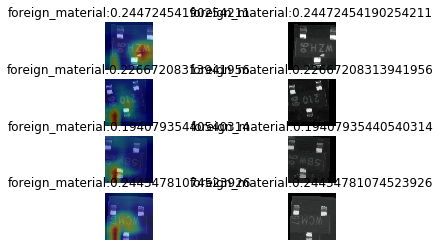

In [30]:
# plot activation maps from images provided by dataloader in a batch
plot_activ(model_ft)

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


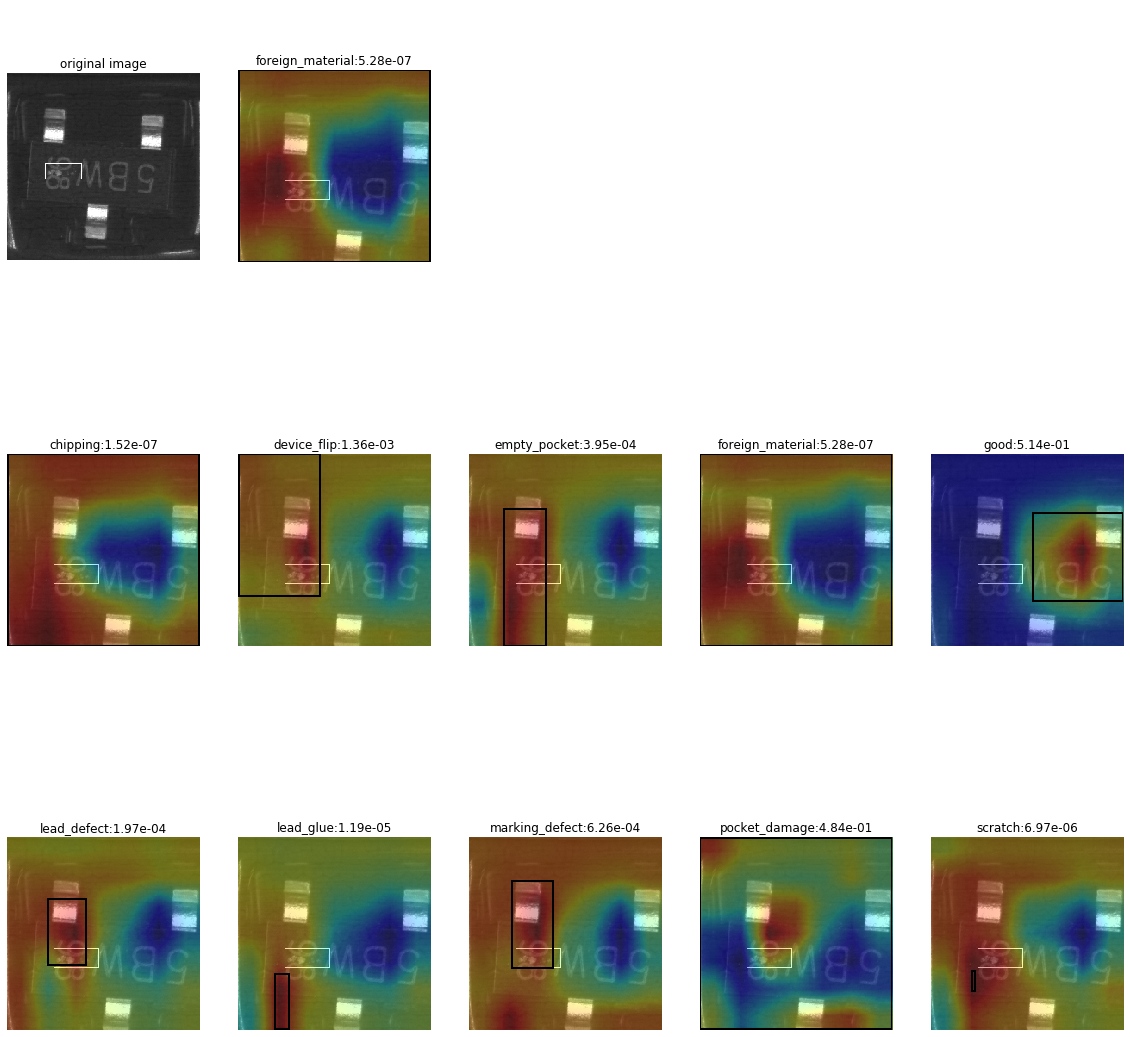

In [44]:
img_path = '/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93224492A_01-APG_ITIS_H53_1_890_4.bmp'
# one true bad sample
plot_cam_given_multi_label(model_ft, img_path, class_idx=3, box_coord=[54,129,106,151])

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


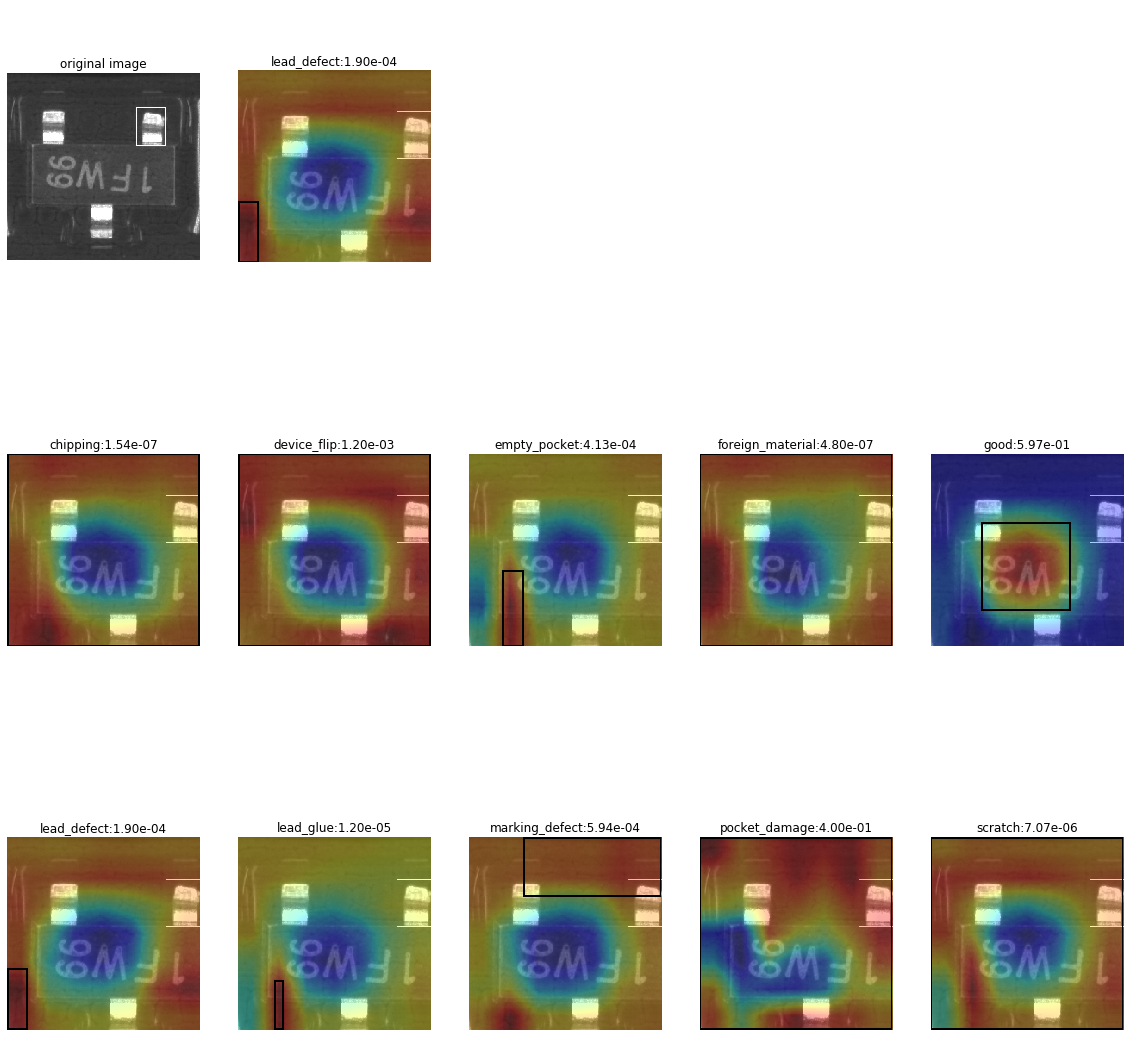

In [45]:
img_path = '/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp'
# one suspected good sample
plot_cam_given_multi_label(model_ft, img_path, box=[(184,49),(225,103)], class_idx=5)

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


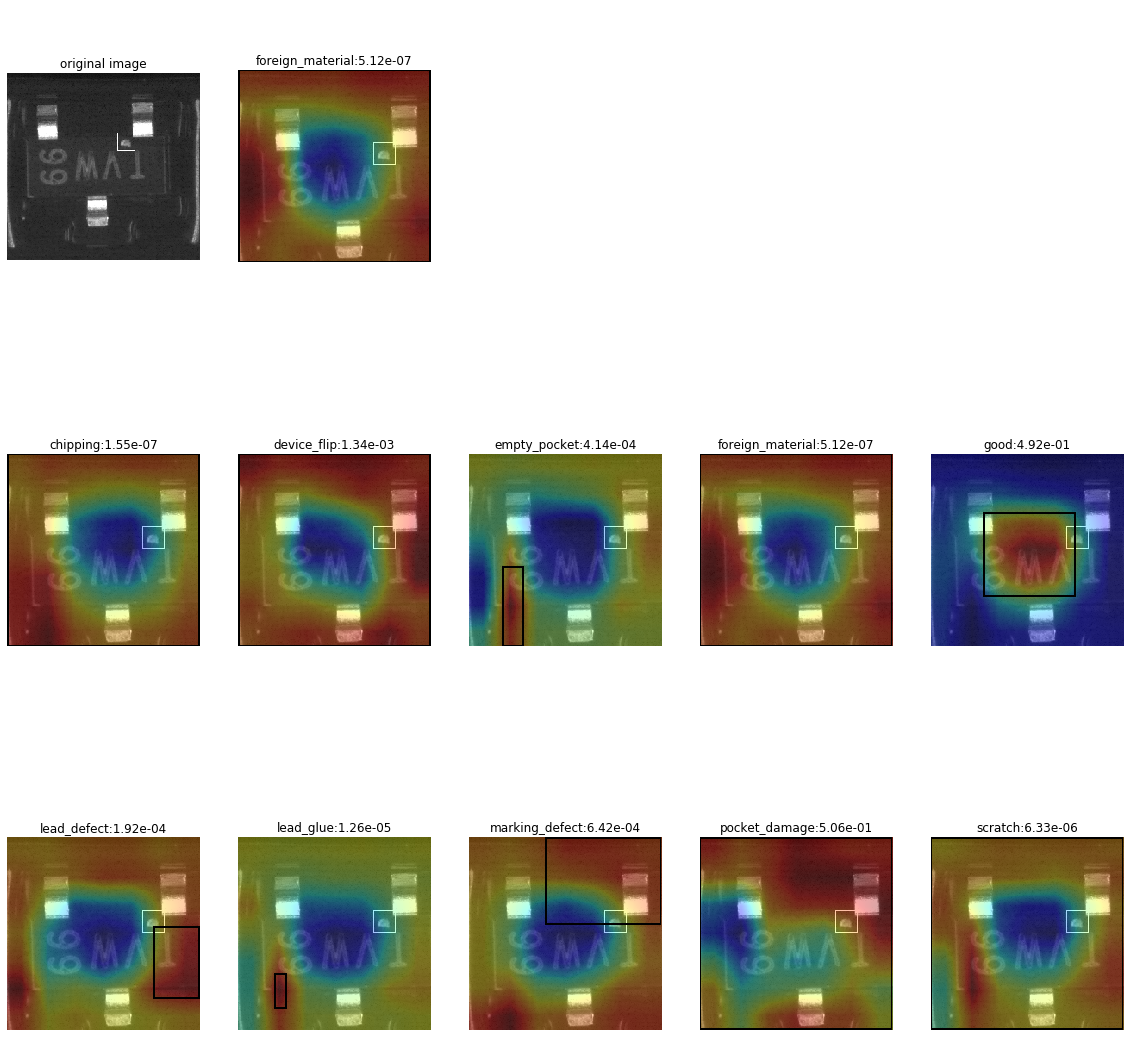

In [46]:
img_path = '/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp'
# one suspected good sample
plot_cam_given_multi_label(model_ft, img_path, box=[(157,85),(182,110)], class_idx=3)

In [224]:
# one suspected good sample
plot_cam_given(model_ft, img_path, box=[(157,85),(182,110)], class_idx=3)

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


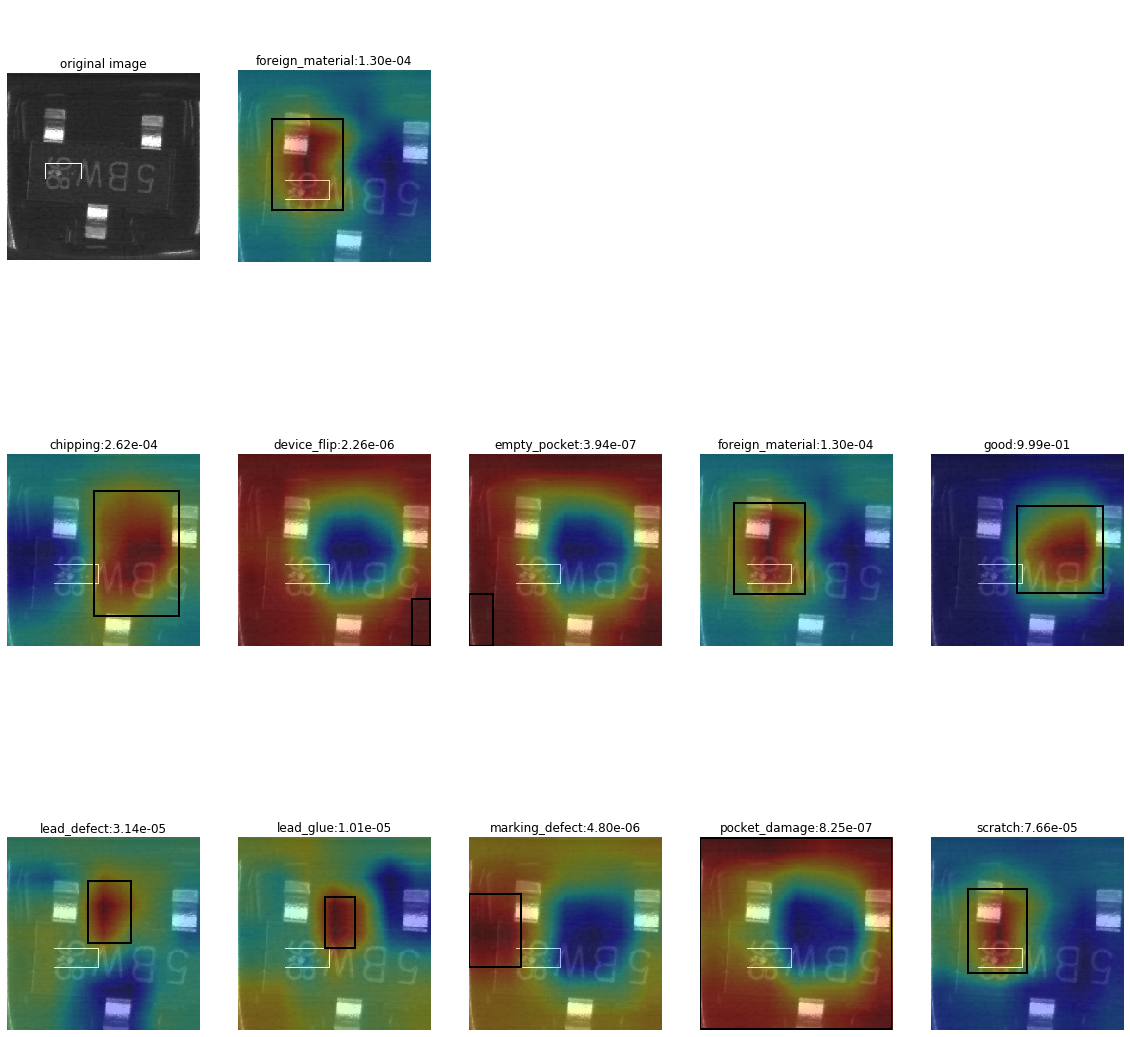

In [220]:
# one true bad sample
plot_cam_given(model_ft, img_path, class_idx=3, box_coord=[54,129,106,151])

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


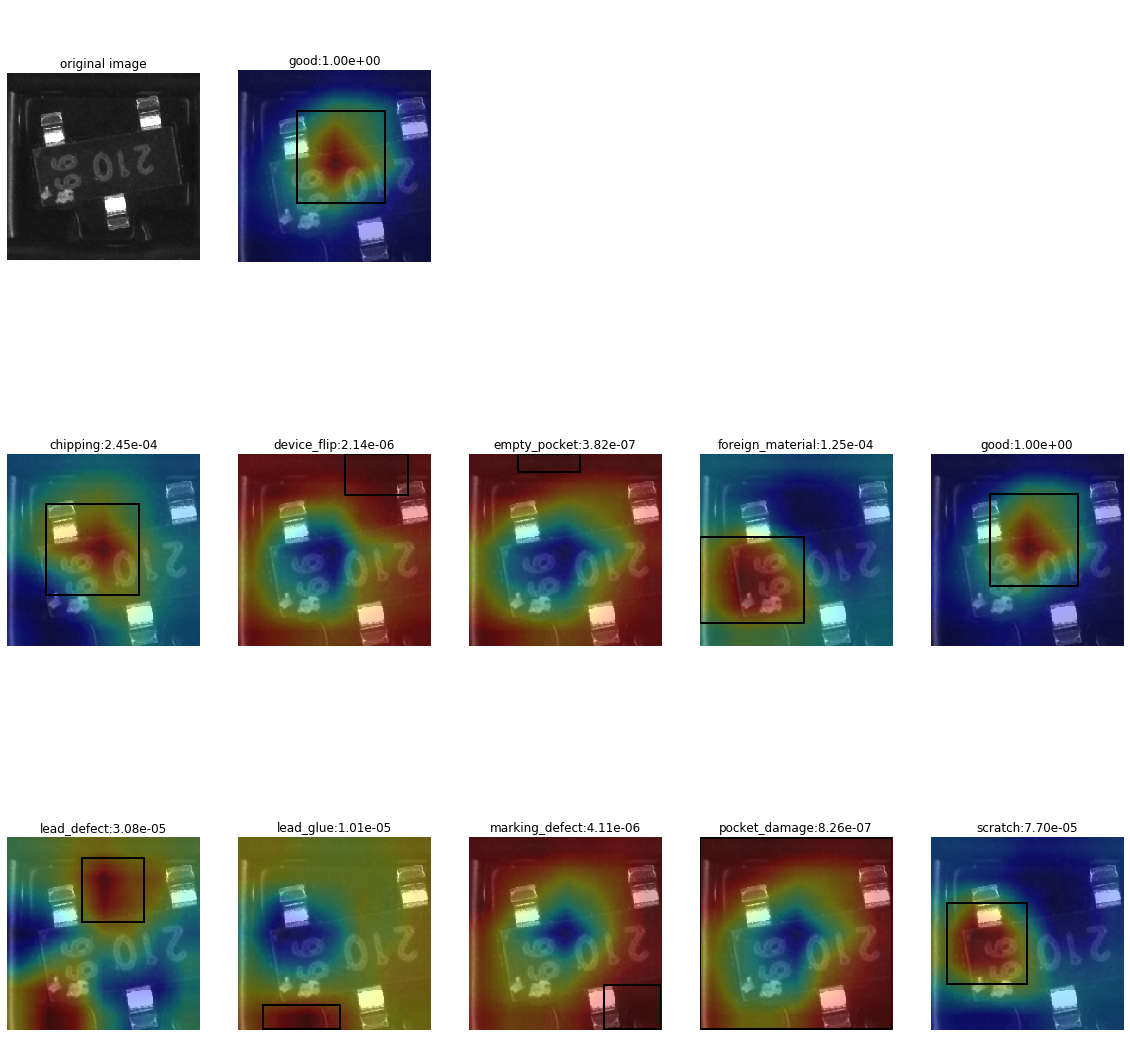

In [217]:
# one suspected bad sample
plot_cam_given(model_ft, img_path, class_idx=4)

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


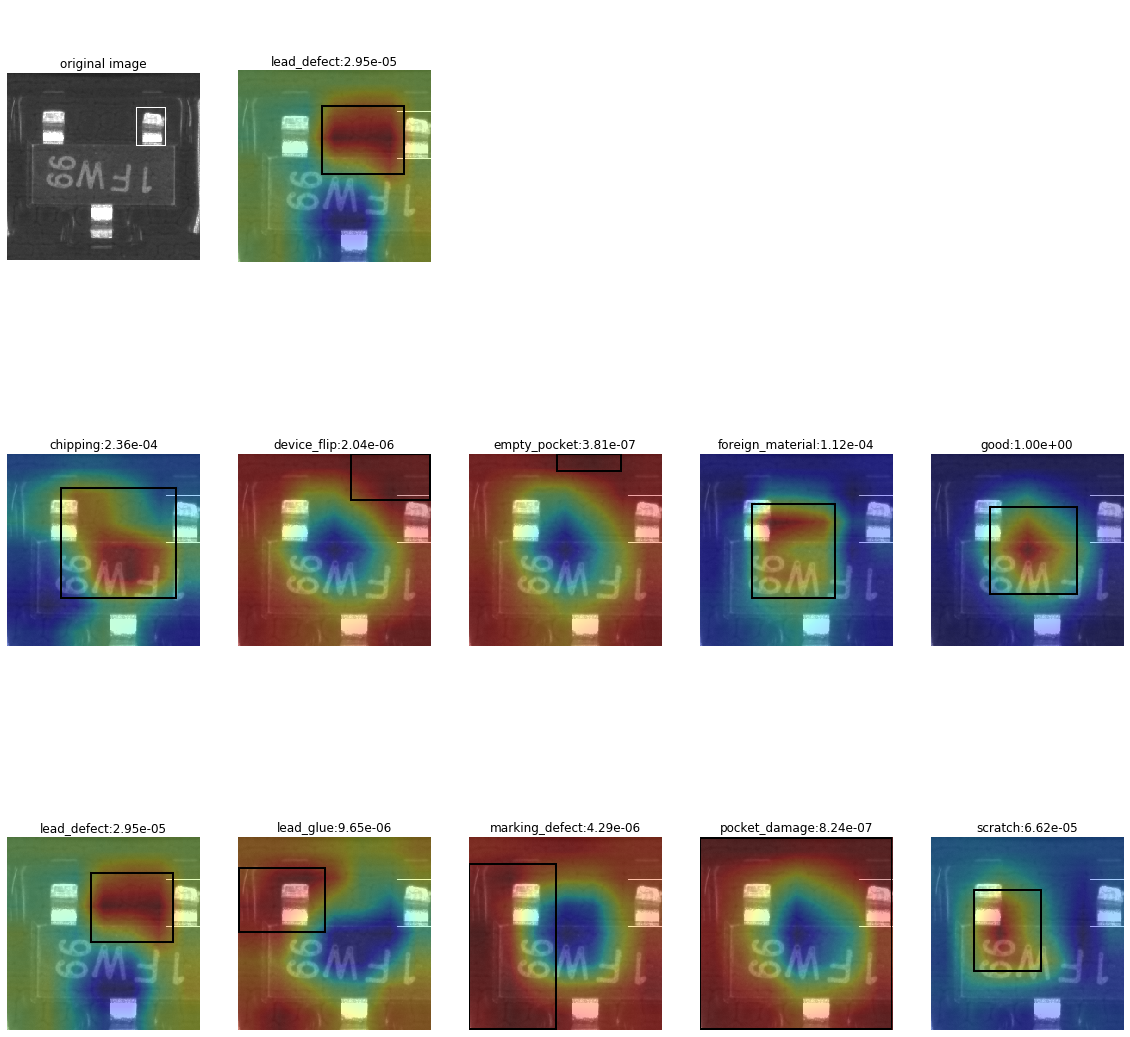

In [210]:
# one suspected good sample
plot_cam_given(model_ft, img_path, box=[(184,49),(225,103)], class_idx=5)

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


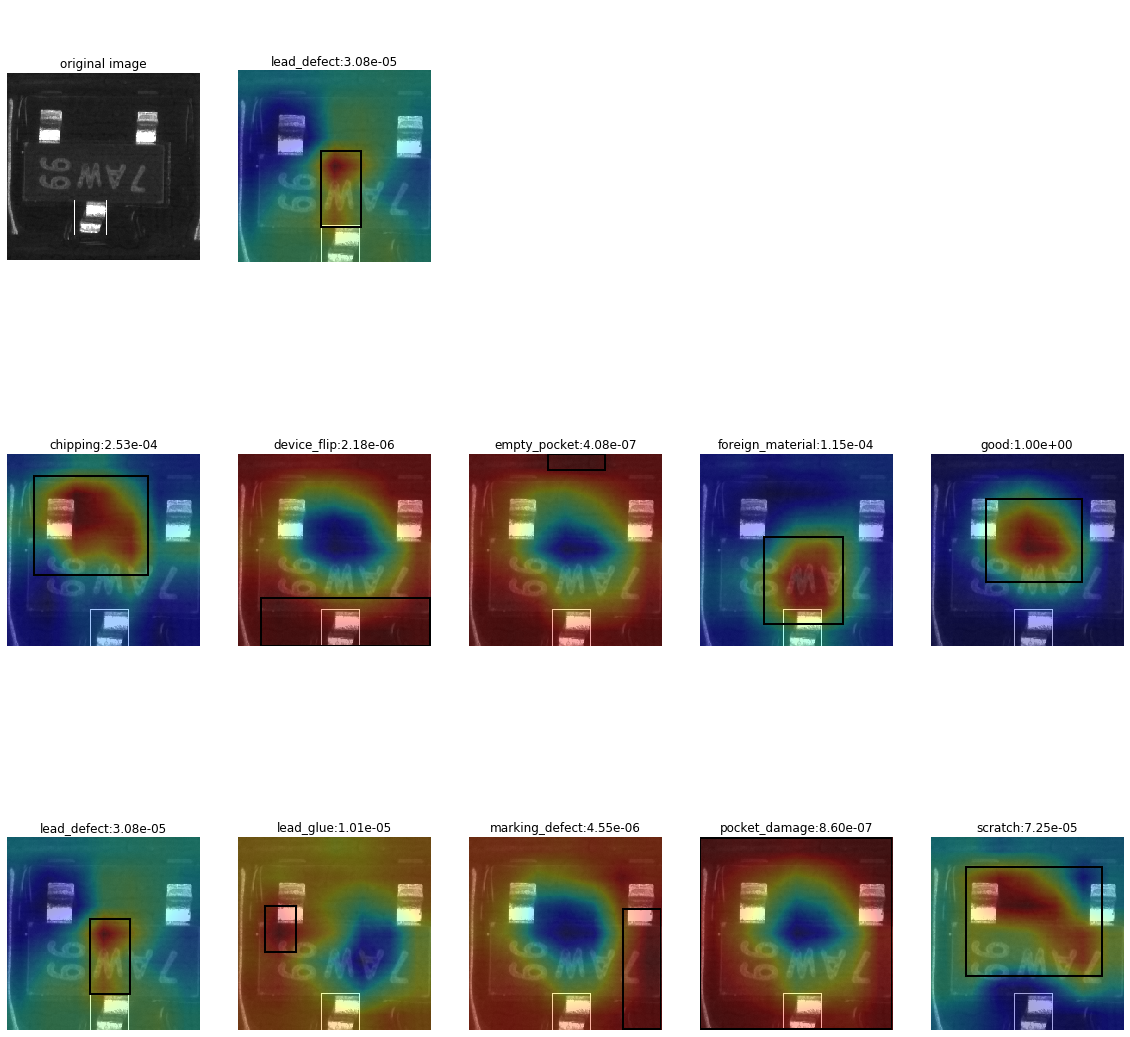

In [208]:
# one suspected good sample
plot_cam_given(model_ft, img_path, class_idx=5, box=[(96,181),(141,231)])

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


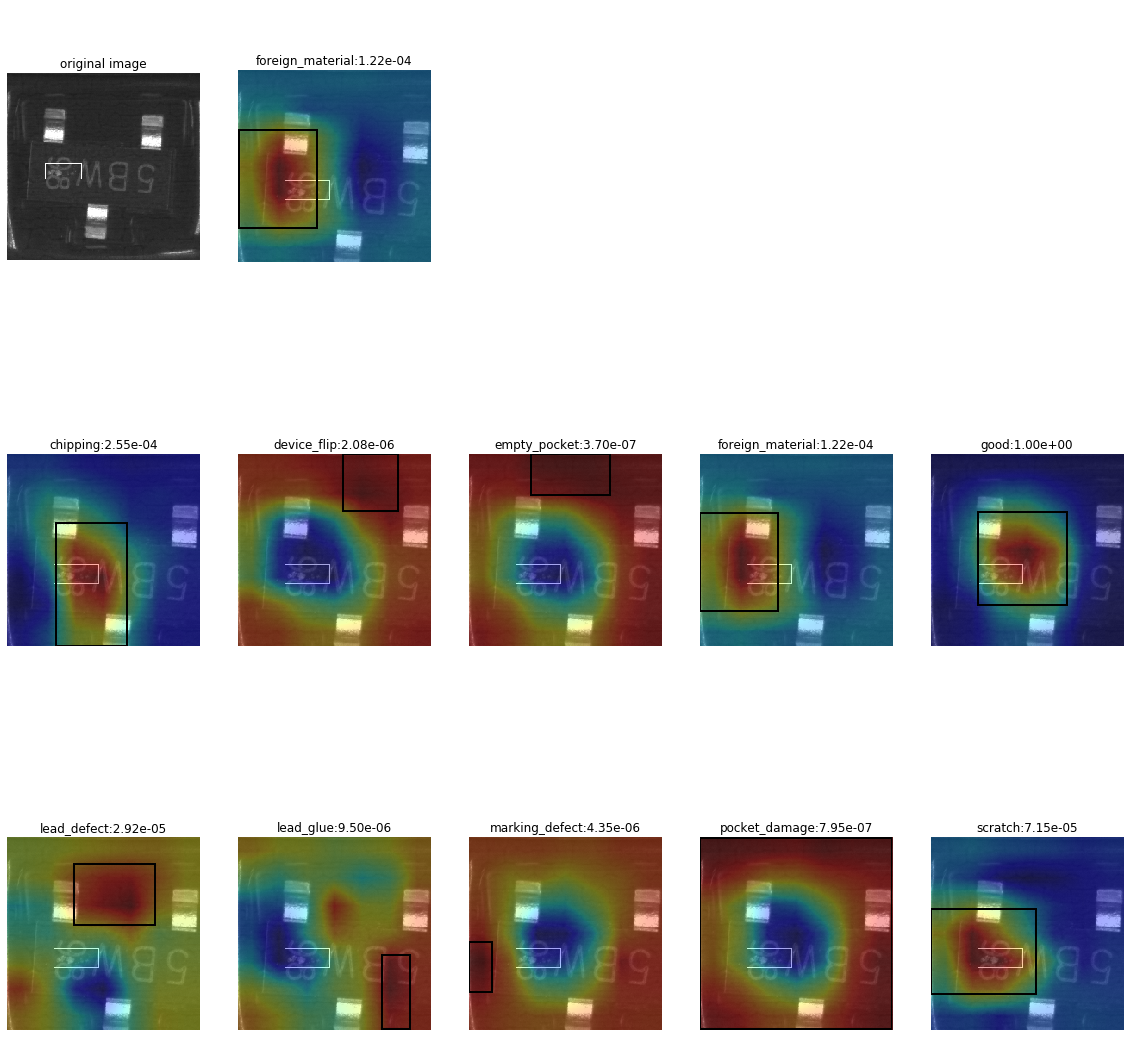

In [202]:
# one true bad sample
plot_cam_given(model_ft, img_path, class_idx=3, box_coord=[54,129,106,151])

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


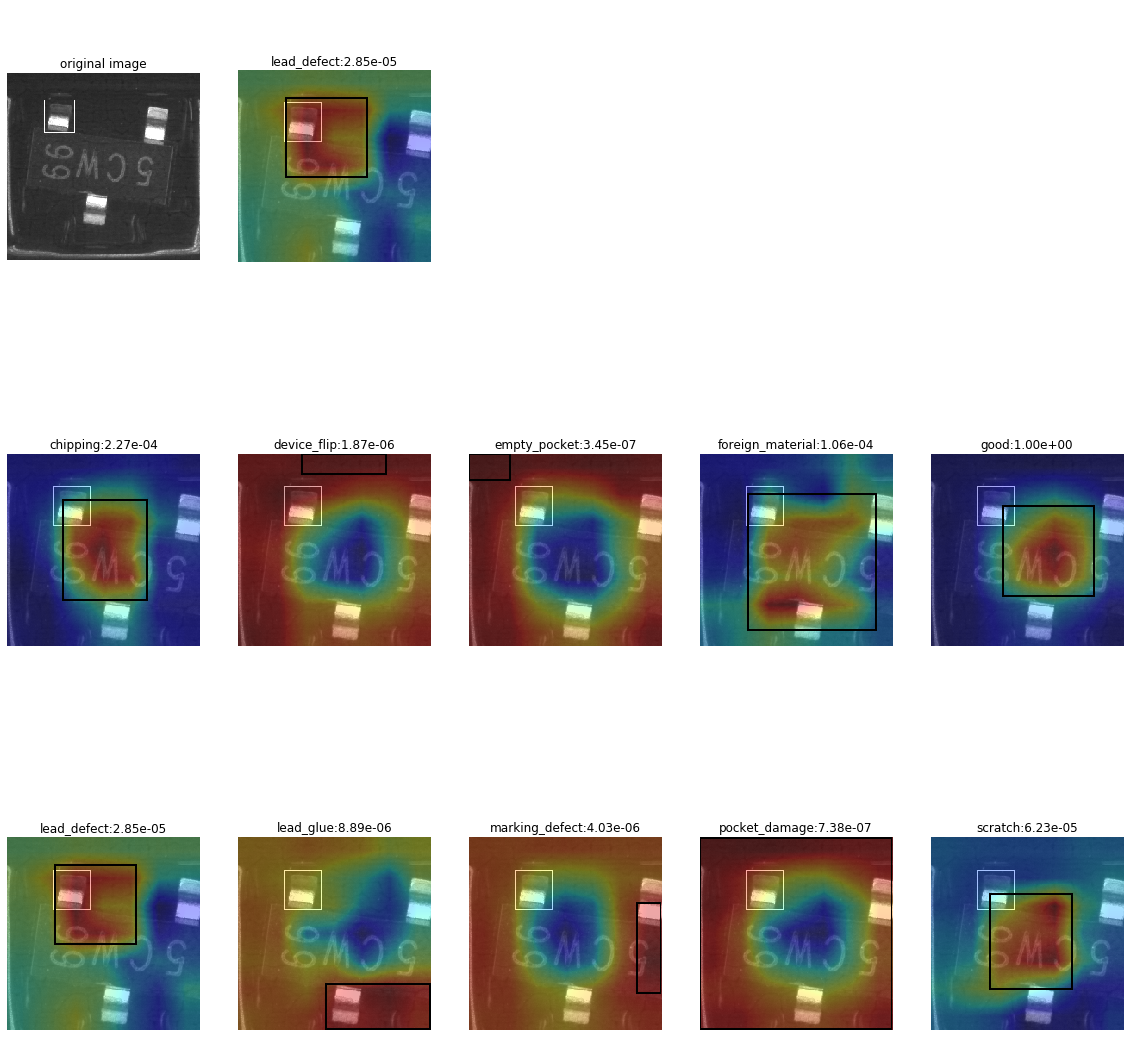

In [200]:
# one suspected good sample
plot_cam_given(model_ft, img_path, box=[(53,38),(96,84)], class_idx=5)

In [1]:
!nvidia-smi

Mon Jul 20 11:29:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   24C    P8    10W / 250W |   5539MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   25C    P8     8W / 250W |    147MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G